In [1]:
from model.Autoencoder import Model
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("btc.csv").iloc[-100000:]
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Date', inplace=True)
df = df[['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Weighted_Price']].rename(columns={'Volume_(BTC)': 'Volume'})
missing_before = df.isnull().sum().to_numpy()
df.fillna(method='ffill', inplace=True)
missing_after = df.isnull().sum().to_numpy()
df.head()

,Open,High,Low,Close,Volume,Weighted_Price
Date,,,,,,
2021-01-20 13:21:00,34379.61,34379.61,34202.71,34280.81,26.173612,34256.666368
2021-01-20 13:22:00,34276.37,34338.75,34245.21,34338.75,2.263786,34281.454865
2021-01-20 13:23:00,34335.18,34376.52,34287.40,34376.52,22.712301,34302.817584
2021-01-20 13:24:00,34354.86,34422.89,34344.75,34378.01,4.494266,34378.176105
2021-01-20 13:25:00,34362.78,34482.90,34362.78,34441.10,1.558702,34409.869899


In [3]:
pd.DataFrame([missing_before, missing_after], index=['before', 'after'], columns=df.columns)

,Open,High,Low,Close,Volume,Weighted_Price
before,131,131,131,131,131,131
after,0,0,0,0,0,0


In [4]:
nn = Model(df, columns=['Close', 'Volume'])
nn

Model(dataframe=df, columns=ListWrapper(['Close', 'Volume']), n_of_units=512, dropout_rate=0.4, time_steps=5)

In [5]:
nn.train_split()
# nn.plot_kfilter()

Train shape: (95000, 3), Test shape: (5000, 2)


In [6]:
nn.scaling()
nn.prepare_data()
nn.build_model()

X_train Shape: (94995, 5, 2), X_test Shape: (4995, 5, 2)


In [7]:
nn.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (LSTM)          (None, 5, 512)            1054720   
                                                                 
 encoding_layer_1 (LSTM)     (None, 5, 256)            787456    
                                                                 
 encoding_layer_2 (LSTM)     (None, 128)               197120    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 128)           0         
 )                                                               
                                                                 
 decoding_layer_1 (LSTM)     (None, 5, 128)            131584    
                                                                 
 decoding_layer_2 (LSTM)     (None, 5, 256)            394240    
                                                        

In [8]:
nn.train_model(epochs=250, verbose=1)

Model: 512-256-128seq_250eps_128bs_5ts_0.1KFconst-Close, Volume is loaded!


In [9]:
nn.save_model()

Another model with the same name was already saved... Use override arg to proceed


In [10]:
nn.predict_test()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
nn.plot_anomaly(prominence=150, distance=50)
nn.close_vs_loss()

In [12]:
from matplotlib import pyplot as plt
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import pandas as pd

ff = pd.read_csv("btc.csv").iloc[-100000:]
ff['Date'] = pd.to_datetime(ff['Timestamp'], unit='s')
ff.set_index('Date', inplace=True)
ff = ff[['Close', 'Volume_(BTC)']].rename(columns={'Volume_(BTC)': 'Volume'})
missing_before = ff.isnull().sum().to_numpy()
ff.fillna(method='ffill', inplace=True)
missing_after = ff.isnull().sum().to_numpy()
ff.head()

,Close,Volume
Date,,
2021-01-20 13:21:00,34280.81,26.173612
2021-01-20 13:22:00,34338.75,2.263786
2021-01-20 13:23:00,34376.52,22.712301
2021-01-20 13:24:00,34378.01,4.494266
2021-01-20 13:25:00,34441.10,1.558702


X_pred: (50, 5, 1) - X: (50,) - loss: (50, 5, 1) - df: (55, 2) - 


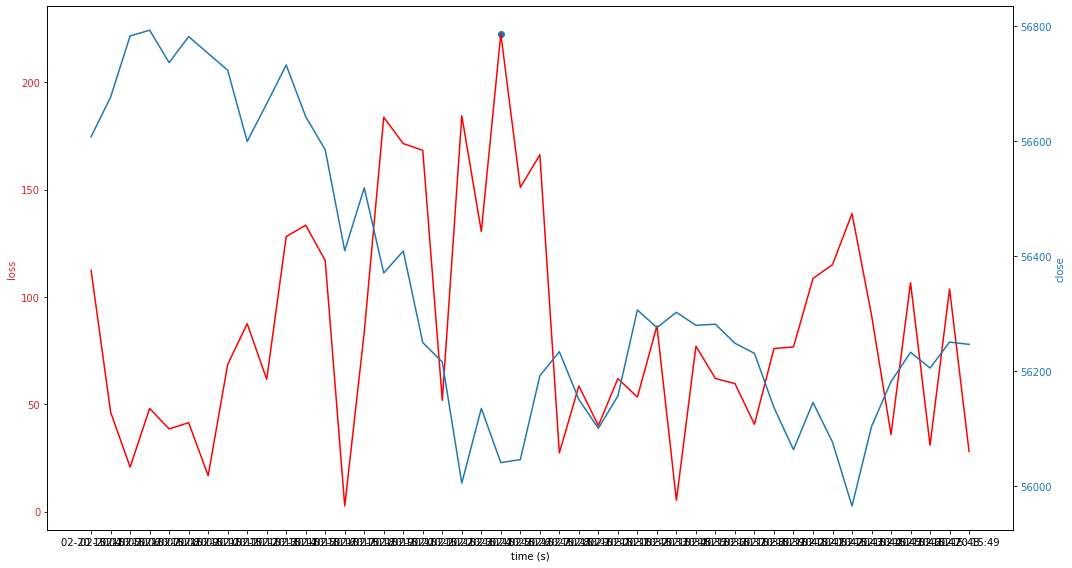

False

In [59]:
import numpy as np
def get_prediction(dataframe, date_string, prominence=70):
    dataframe = dataframe.reset_index().reset_index()
    dataframe.set_index('Date', inplace=True)
    t = int(dataframe.loc[date_string, 'index'])
    k = dataframe.iloc[max(t-50, 5): t + 1]
    k.drop(columns=["index"], inplace=True)
    df = k.copy()
    df_ = df.append([np.nan, np.nan, np.nan, np.nan], ignore_index=False).fillna(method="ffill").drop(columns=[0])
    anomaly_indices, loss, X = nn.single_scaling(df_.copy(), prominence=prominence)
    loss = loss[:-4]
    X = X[:-4]
    df_ = df.copy()[5:]
    z = pd.DataFrame(loss, columns=['loss'])
    z['Date'] = df_.index.strftime('%m-%d %H:%M')
    z["index"] = df_.index
    z.set_index("index", inplace=True)
    z['Close'] = df_['Close']
    z.reset_index(inplace=True)
    z['anomaly'] = False
    z.iloc[anomaly_indices, z.columns.get_loc('anomaly')] = True
    # Create some mock data
    t = np.arange(0.01, 10.0, 0.01)
    data1 = np.exp(t)
    data2 = np.sin(2 * np.pi * t)

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('loss', color=color)
    ax1.plot(z['Date'], z['loss'], color = "red")
    ax1.scatter(z.query("anomaly == True").index, z.query("anomaly == True")['loss'])
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('close', color=color)  # we already handled the x-label with ax1
    ax2.plot(z['Date'], z['Close'])
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()
    # plt.plot(z['Date'], z['loss'])
    # plt.plot(z['Date'], z['Close'])
    # plt.xticks(rotation=90)
    # plt.grid()
    # plt.scatter(z.query("anomaly == True").index, z.query("anomaly == True")['loss'])
    # plt.twinx()
    # plt.show()
    return z.iloc[-1]['anomaly']

get_prediction(ff, "2021-02-20 15:49:00", 140)
# datetime.datetime.strptime("2021-01-20 13:21:00", "%Y-%m-%d %H:%M:%S") datetime.timedelta()

In [ ]:
# idx = 50000 - (175- 73)
# df = ff.iloc[idx:idx + 200][25:]


X_pred: (50, 5, 1) - X: (50,) - loss: (50, 5, 1) - df: (55, 2) - 
(46,)


In [ ]:
df_['loss'] = loss
df_['X'] = X.reshape(-1, 1)
df_['xx'] = df['Close']
df_.head()

,Close,Volume,loss,X,xx
Date,,,,,
2021-02-20 12:58:00,57384.59,4.843794,6.792969,57384.59,57384.59
2021-02-20 12:59:00,57282.50,1.420818,80.155312,57282.50,57282.50
2021-02-20 13:00:00,57331.47,5.392015,89.232500,57331.47,57331.47
2021-02-20 13:01:00,57297.78,4.753403,174.854688,57297.78,57297.78
2021-02-20 13:02:00,57289.60,3.172437,89.154219,57289.60,57289.60


index               45
loss         168.60125
Date       02-20 13:43
anomaly           True
Name: 45, dtype: object

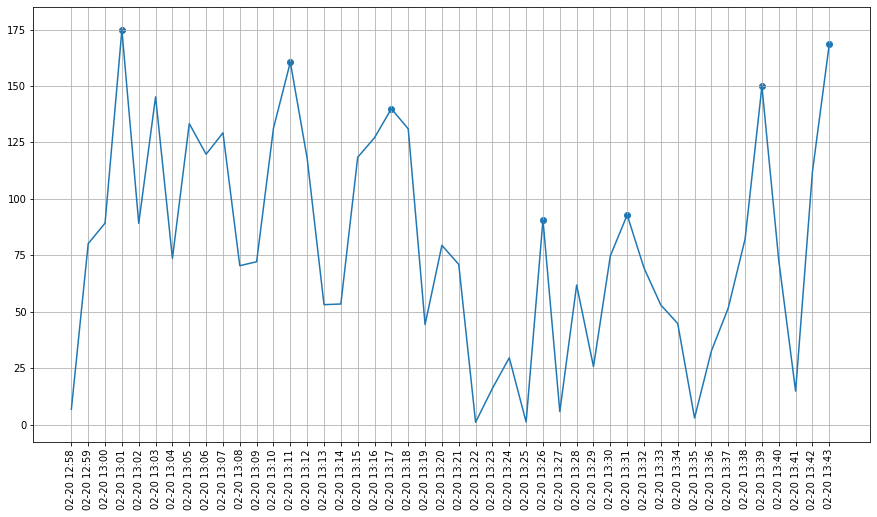

In [ ]:
z = pd.DataFrame(loss, columns=['loss'])
z['Date'] = df_.index.strftime('%m-%d %H:%M')
prominence = 70
z.reset_index(inplace=True)
# anomaly_indices = find_peaks(z['loss'], prominence=prominence)[0]
z['anomaly'] = False
z.iloc[anomaly_indices, z.columns.get_loc('anomaly')] = True
plt.plot(z['Date'], z['loss'])
plt.xticks(rotation=90)
plt.grid()
plt.scatter(z.query("anomaly == True").index, z.query("anomaly == True")['loss'])
z.iloc[-1]